# Sarsa & Q-Learning

Sarsa and Q-Learning are on and off policy implementations of general policy iteration with one-step backups that act on state-action values. Put differently, they are two of many possible instantiations of TD(0) control. Let's review the update equations.

$$\textbf{Sarsa}$$
$$ Q(s,a) \leftarrow (1-\alpha)Q(s,a) + \alpha[r+\gamma Q(s', a')] $$

$$\textbf{Q-Learning}$$
$$ Q(s,a) \leftarrow (1-\alpha)Q(s,a) + \alpha[r+\gamma \max_{a'} Q(s', a')] $$

The only different you can see immediately is that in Q-Learning we pick $a'$ to be the action that maximizes $Q(s',a')$, and in Sarsa we don't. But how does Sarsa pick $a'$? Sarsa picks $a'$ according to the policy being evaluated (presumably some $\epsilon$-greedy function of Q. This is why Sarsa is on-policy and Q-Learning is off policy.

Here we are going to answer all the exercises related to section 6.4.

## Example 6.7

In [29]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3)

[ 0.  0.  0.  0.] [0 1 2 3] 1
[ 0.  0.  0.  0.] [0 1 2 3] 3
[ 0.  -0.1  0.   0. ] [0 2 3] 2
[ 0.  -0.1  0.  -0.1] [0 2] 0
[ 0.  0.  0.  0.] [0 1 2 3] 2
[ 0.  0.  0.  0.] [0 1 2 3] 0
[ 0.  0.  0.  0.] [0 1 2 3] 2
[ 0.  0.  0.  0.] [0 1 2 3] 2
[ 0.  0.  0.  0.] [0 1 2 3] 1
[ 0.  0.  0.  0.] [0 1 2 3] 0
[ 0.  -0.1  0.   0. ] [0 2 3] 0
[ 0.  0.  0.  0.] [0 1 2 3] 2
[ 0.  0.  0.  0.] [0 1 2 3] 0
[ 0.  0.  0.  0.] [0 1 2 3] 0
[-0.1  0.   0.   0. ] [1 2 3] 2
[ 0.  0.  0.  0.] [0 1 2 3] 2
[ 0.  0.  0.  0.] [0 1 2 3] 1
[ 0.  0.  0.  0.] [0 1 2 3] 3
[ 0.  0.  0.  0.] [0 1 2 3] 2
[ 0.   0.   0.  -0.1] [0 1 2] 2
[ 0.  0.  0.  0.] [0 1 2 3] 3
[ 0.   0.  -0.1 -0.1] [0 1] 0
[-0.091  0.    -0.1   -0.1  ] [1] 1
[ 0.  0.  0.  0.] [0 1 2 3] 1
[ -0.1  -0.1 -10.   -0.1] [0 1 3] 1
[ -0.1  -0.1 -10.   -0.1] [0 1 3] 0
[ 0.   0.  -0.1  0. ] [0 1 3] 1
[ -0.19   -0.181 -10.     -0.1  ] [3] 3
[ -0.19   -0.181 -10.     -0.1  ] [3] 3
[ -0.19   -0.181 -10.     -0.181] [1 3] 1
[ -0.19   -0.181 -10.     -0.247] [1] 1


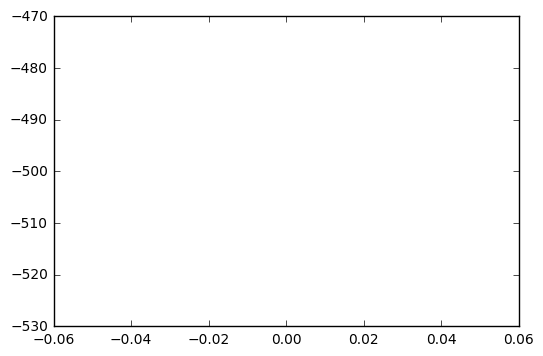

In [60]:
def env_step(s, a):
    s_ = s
    if a == 0: #N
        if s[0] > 0:
            s_ = (s[0]-1, s[1])
    elif a == 1: #S
        if s[0] < 3:
            s_ = (s[0]+1, s[1])
    elif a == 2: #E
        if s[1] < 11:
            s_ = (s[0], s[1]+1)
    elif a == 3: #W
        if s[1] > 0:
            s_ = (s[0], s[1]-1)
    else:
        raise ValueError("a must be between 0 and 3 inclusive, but is {}".format(a))
        
    if s_ == (3, 11):
        r = 1
        s_ = (3, 0) # back to start
    elif s_[0] == 3 and 0 < s_[1]:
        r = -100
        s_ = (3, 0) # back to start
    else:
        r = -1
    
    return s_, r

def sarsa(Pi, alpha=0.1, gamma=0.9, debug=False):
    Q = np.zeros((4,12,4))
    E = 1
    steps = 100
    rewards = []
    for i in range(E):
        s = (3, 0)
        a = Pi(Q, s)
        reward = 0
        for j in range(steps):
            s_, r = env_step(s, a)
            reward += r
            a_ = Pi(Q, s_)
            if debug:
                print(s, a, r, s_, Q[s[0], s[1], a])
            Q[s[0], s[1], a] = (1 - alpha)*Q[s[0], s[1], a] + alpha*(r - gamma*Q[s_[0], s_[1], a_])
            if debug:
                print(Q[s[0], s[1], a])
            s = s_
            a = a_
        if debug:
            print(reward)
        rewards.append(reward)
    
    return Q, rewards

def epsilon_greedy(Q, s, epsilon=0.05):
    if np.random.rand() < epsilon:
        a = np.random.randint(0,4)
    else:
        a_s = np.argwhere(Q[s] == np.max(Q[s]))
        a = np.random.choice(a_s.flatten())
        print(Q[s], a_s.flatten(), a)
        
    return a

np.random.seed(0)
sarsa_V, sarsa_rewards = sarsa(epsilon_greedy)

plt.plot(sarsa_rewards)
plt.show()